In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from fbprophet import Prophet
import altair as alt
import glob 

#print("5 :: middle is shorter in time in both eyes, initial peak maybe for the new task")
#print("6 :: Hight peak in left eye on third and last spike, nothing on right")
#print("8 :: major peak in the middle. both eyes. Even a negative value")
#print("9 :: ????")
#print("10 :: right spike at the end, left spike in the middle")
#print("11 :: a lot of spikes at random. mostly left eye")
#print("12 :: major spike in the middle, left eye. Right eye almost negative (lower than mean)")
#print("13 :: ????")
#print("14 :: major right spike in the middle, major left spikes at the begin and at the end")
#print("15 :: major left spike at the begin")

alt.renderers.enable('notebook')
pd.options.mode.chained_assignment = None  # default='warn'

annotations_in_temp = "data/annotations/s{}.csv"
tobii_in_temp = "data/tobii/s{}.csv"
subject_cards_file = "data/cards.csv"
features_out = "data/features.csv"


In [2]:
def clearFloats(x):
    if(type(x) == str):
        x = x.replace('\U00002013', '-').replace(',', '.')
    return x

In [3]:
def preprocessEye(eye_file):
    # read the eye file
    df = pd.read_csv(eye_file, encoding='utf-16', sep='\t')
    
    # rename columns
    df.columns = ['timestamp','prj_name','exp_date','name','rec_name','rec_date','start_time','duration',
                  'rec_fix_filter_name','event','event_val','gaze_x','gaze_y','gaze_3d_x','gaze_3d_y','gaze_3d_z',
                  'gaze_dir_right_x','gaze_dir_right_y','gaze_dir_right_z','gaze_dir_left_x','gaze_dir_left_y',
                  'gaze_dir_left_z','pupil_pos_left_x','pupil_pos_left_y','pupil_pos_left_y',
                  'pupil_pos_right_x','pupil_pos_right_y','pupil_pos_right_z','diam_left', 'diam_right',
                  'rec_media_name', 'rec_media_width', 'rec_media_heigh',
                  'move_type','event_dur','move_type_id','fix_x','fix_y',
                  'gyro_x','gyro_y', 'gyro_z','acc_x', 'acc_y', 'acc_z',
                  'ID']
        
    # remove useless columns
    df = df.drop(['ID','prj_name','exp_date', 'rec_name', 'duration', 'rec_fix_filter_name',
                 'rec_media_name', 'rec_media_width', 'rec_media_heigh',
                 'gyro_x','gyro_y', 'gyro_z','acc_x', 'acc_y', 'acc_z'], axis=1)
    
    # remove useless events
    df = df[df.move_type != "EyesNotFound"]
    df = df[df.event != "RecordingStart"]
    df = df[df.event != "RecordingEnd"]
    df = df[df.event != "SyncPortOutHigh"]
    df = df[df.event != "SyncPortOutLow"]
    df = df.drop(['event', 'event_val'], axis=1)
    
    # set datatypes
    df = df.applymap(clearFloats)
    dfe = df.apply(pd.to_numeric, errors='ignore')
    
    #dfe['dt_index'] = pd.to_datetime(dfe['rec_date'] + ' ' + dfe['start_time'], \
    #                                 format="%d/%m/%Y %H:%M:%S.%f") + \
    #                                pd.to_timedelta(dfe['timestamp'], unit='ms')
    
    dfe['dt_index'] = pd.to_datetime(dfe['start_time'], \
                                     format="%H:%M:%S.%f") + \
                                    pd.to_timedelta(dfe['timestamp'], unit='ms')
    
    dfe = dfe.set_index(pd.DatetimeIndex(dfe['dt_index']))
    
    return dfe

In [4]:
def preprocessAnnotations(annotation_file, card_names):
    # read the eye file
    annot = pd.read_csv(annotation_file, sep='\t', names=['tire', 'remove', 'start', 'stop', 'duration', 'class'])
    annot = annot.drop(['remove'], axis=1)
    
    annot['start_ms'] = annot['start'].apply(stringToMSec)
    annot['stop_ms'] = annot['stop'].apply(stringToMSec)
    annot['duration_ms'] = annot['duration'].apply(stringToMSec)
    
    # DON'T WORK!!
    # convert timestamps
    #start_time_dt = pd.to_datetime(start_time, format="%H:%M:%S.%f")
    #annot['start_dt'] = start_time_dt + pd.to_timedelta(annot['start'].apply(stringToMSec), unit='ms')
    #annot['stop_dt'] = start_time_dt + pd.to_timedelta(annot['stop'].apply(stringToMSec), unit='ms')
    #annot['duration_dt'] = pd.to_timedelta(annot['duration'].apply(stringToMSec), unit='ms')
    
    annot = annot.drop(['start', 'stop', 'duration'], axis=1)
    default = annot.loc[annot['tire'] == "default"]
    
    dfs = [default]
    
    for card in card_names:
        dfs.append(
            annot.loc[(annot['tire'] == "per_card") & (annot['class'] == card)]
        )
        
    return dfs

In [5]:
def stringToMSec(time):
    h, m, sms = time.split(':')
    s, ms = sms.split('.')
    return 1000 * (int(h)*3600 + int(m)*60 + int(s)) + int(ms)

def normalize(df, column):
    max_value = df[column].max()
    min_value = df[column].min()
    df.loc[:, column] = (df[column] - min_value) / (max_value - min_value)
    
    return df


In [22]:
def filterEyeData(eyeDF, annot):
    annot = annot.reset_index()
    start = annot.at[0, 'start_ms']
    stop = annot.at[0, 'stop_ms']
    
    novelty = eyeDF.loc[(eyeDF['timestamp'] >= start) & (eyeDF['timestamp'] <= stop)]
    
    # RESAMPLE
    novelty['diam_right'] = pd.DataFrame(novelty['diam_right'].resample("ms").mean().fillna(method='bfill'))
    novelty['diam_left'] = pd.DataFrame(novelty['diam_left'].resample("ms").mean().fillna(method='bfill'))
    
    # Normalize usefull data
    #novelty = normalize(novelty, 'diam_right')
    #novelty = normalize(novelty, 'diam_left')

    return novelty


def filterShortEyeResponse(eyeDF, annot):
    annot = annot.reset_index()
    start = annot.at[0, 'start_ms']
    stop = annot.at[0, 'stop_ms']    
    short_stop = start + 1500 #look to a window of 1.5 seconds after the stimulus
    
    short_stop = min(short_stop, stop)    
    short_response = eyeDF.loc[(eyeDF['timestamp'] >= start) & (eyeDF['timestamp'] <= short_stop)]
    
    # RESAMPLE
    novelty['diam_right'] = pd.DataFrame(novelty['diam_right'].resample("ms").mean().fillna(method='bfill'))
    novelty['diam_left'] = pd.DataFrame(novelty['diam_left'].resample("ms").mean().fillna(method='bfill'))
    
    # Normalize usefull data
    #novelty = normalize(novelty, 'diam_right')
    #novelty = normalize(novelty, 'diam_left')

    return novelty

In [23]:
def loadTimeSeries(subject, card_names,
                   tobbi_input_template=tobii_in_temp,
                   annot_input_template=annotations_in_temp):
    
    f_in = tobbi_input_template.format(subject)
    annot_in = annot_input_template.format(subject)
    
    # vector with temporal filtered data for each card
    cards = []
    
    # load topii data
    eye = preprocessEye(f_in.format(subject))
    
    # load novelty annotations
    annotations = preprocessAnnotations(
        annot_in.format(subject), card_names)
    
    # filter eye data relative to overall novelty phase
    overall = filterEyeData(eye, annotations[0])
    
    # single single cards eye data
    for i in range(1, len(annotations)):
        c = filterEyeData(eye, annotations[i])
        c['class'] = annotations[i]['class'].iloc[0]
        cards.append(c)
    
    return eye, annotations, overall, cards

In [24]:
def getSubjectCard(subject, cards_file=subject_cards_file):
    s_cards = pd.read_csv(cards_file, sep=';')
    sub_name = "s" + str(subject)
    
    print(sub_name)
    
    card = s_cards.loc[s_cards['subject'] == sub_name]
    return card['card'].values[0]

def plotPupilDilationTimeSeries(subject, card_names, overall_eye, cards_eye,
                                subj_card_in=subject_cards_file):
    
    colors = ['green', 'yellow', 'red', 'purple', 'grey', 'pink']
    cards_plot_features = []
    
    for i in range(0, len(cards_eye)):    
        cards_plot_features.append([
            cards_eye[i].index.min(),
            cards_eye[i].index.max(),
            card_names[i]
        ])    
        
    cards_plot_features.sort()    
    sub_card = getSubjectCard(subject, subj_card_in)
    
    fig, ass = plt.subplots(3, figsize=(15, 15), sharex=True)
    
    ass[0].set_title("RIGHT")
    ass[1].set_title("LEFT")
    ass[2].set_title("BOTH")
    
    
    #ass[0].scatter(overall_eye['timestamp'],overall_eye['diam_right'], s=5)
    
    
    ass[0].plot(overall_eye['diam_right'], c='black')
    ass[1].plot(overall_eye['diam_left'], c='black')
    ass[2].plot(overall_eye['diam_right'])
    ass[2].plot(overall_eye['diam_left'])

    for i in range(0, len(cards_eye)):    
        alp = 0.2
        color = 'green'
        if(cards_plot_features[i][2] == sub_card):
            alp = 1.0
            color = 'yellow'
            
        ass[0].axvspan(cards_plot_features[i][0],
                       cards_plot_features[i][1],
                       linewidth=1, color=color, alpha=alp)
        
        ass[1].axvspan(cards_plot_features[i][0],
                       cards_plot_features[i][1],
                       linewidth=1, color=color, alpha=alp)
        
        ass[2].axvspan(cards_plot_features[i][0],
                       cards_plot_features[i][1],
                       linewidth=1, color=color, alpha=alp)
    plt.show()
    return sub_card

s18
s18


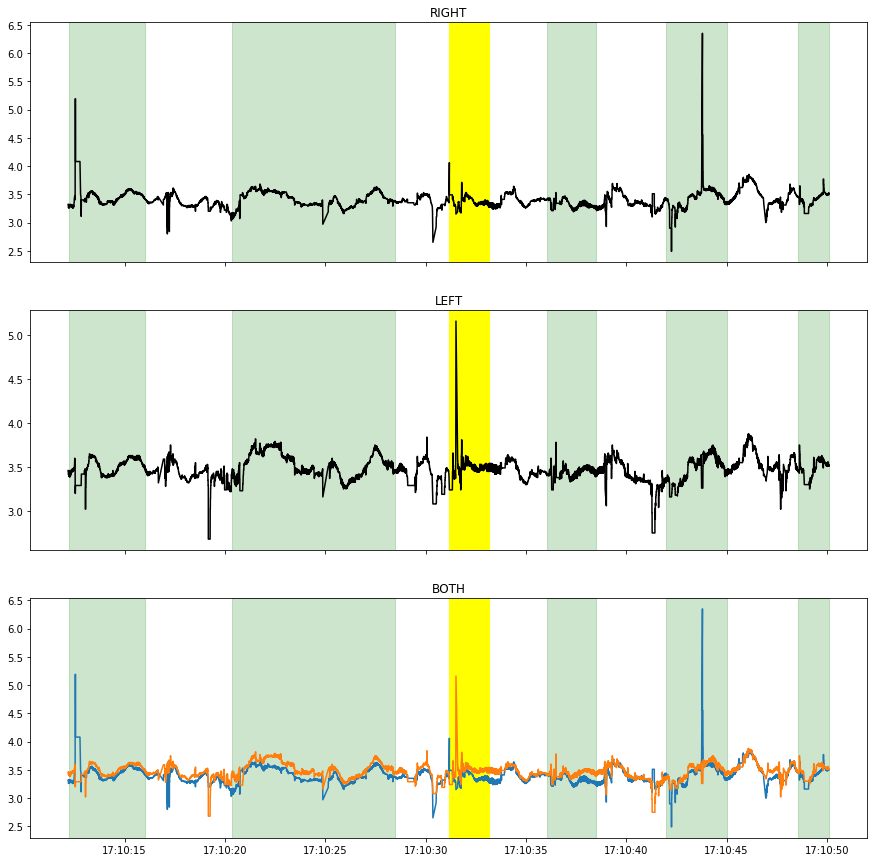

In [27]:
subject = 18
card_names = ['unicorn', 'pepper', 'minion', 'pig', 'hedge', 'aliens']

eye_df, annot_dfs, overall_eye_df, cards_eye_dfs = loadTimeSeries(subject, card_names)
subject_card = getSubjectCard(subject, subject_cards_file)
subject_card = plotPupilDilationTimeSeries(subject, card_names, overall_eye_df, cards_eye_dfs)
#print(subject_card)

In [20]:
class MagicFeatures:
    def __init__(self,
                 subject = None,
                 card = None,
                 subject_one = False,
                 pupil_diam_left_mean = None,
                 pupil_diam_right_mean = None,
                 pupil_diam_left_std = None,
                 pupil_diam_right_std = None,
                 pupil_diam_left_min = None,
                 pupil_diam_right_min = None,
                 pupil_diam_left_max = None,
                 pupil_diam_right_max = None,
                 saccades_num = None,
                 fixation_num = None,
                 duration = None                 
            ):
        self.subject = subject
        
        self.pupil_diam_left_mean = pupil_diam_left_mean
        self.pupil_diam_right_mean = pupil_diam_right_mean
        self.pupil_diam_left_std = pupil_diam_left_std
        self.pupil_diam_right_std = pupil_diam_left_std
        
        self.pupil_diam_left_min = pupil_diam_left_min
        self.pupil_diam_right_min = pupil_diam_right_min
        self.pupil_diam_left_max = pupil_diam_left_max
        self.pupil_diam_right_max = pupil_diam_right_max
    
        duration_sec = duration / 1000
    
        self.saccades_num_per_sec = saccades_num / duration_sec 
        self.fixation_num_per_sec = fixation_num / duration_sec
        
        self.duration = duration
        
        self.card = card
        self.subject_one = subject_one
        
    def getPandaDF(self, cols):
        return pd.DataFrame(
            data=[[
                self.subject,
                self.card,
                self.subject_one,
                self.show_order,
                self.duration,
                self.pupil_diam_left_mean,
                self.pupil_diam_right_mean,
                self.pupil_diam_left_std,
                self.pupil_diam_right_std,
                self.pupil_diam_left_min,
                self.pupil_diam_right_min,
                self.pupil_diam_left_max,
                self.pupil_diam_right_max,
                self.saccades_num_per_sec,
                self.fixation_num_per_sec
                
            ]],
            columns=cols
        )


def collectMagicFeatures(subject,
                         subject_card,
                         annot_dfs,
                         card_eye_dfs,
                         card_eye_response_dfs,
                         feat_df, cols):    
        
    for c, card in enumerate(card_eye_dfs):
        
        # Count Fixation and Saccade
        events = cards_eye_dfs[c][['diam_right', 'diam_left', 'move_type']]
        move_types = events[['move_type']]
        move_types['count'] = 1
        move_types = move_types.groupby('move_type').count()
        fix_num = move_types.loc[move_types.index == "Fixation"].iloc[0][0]
        sacc_num = move_types.loc[move_types.index == "Saccade"].iloc[0][0]
        #print("fix {} sacc {}".format(fix_num, sacc_num))
        
        # Calc Mean of Pupil Dilation
        right_pupil_mean = events['diam_right'].mean(skipna = True)
        left_pupil_mean = events['diam_left'].mean(skipna = True)
        #print("diam mean right {} left {}".format(right_pupil_mean, left_pupil_mean))
        
        # Calc Variation of Pupil Dilation
        right_pupil_std = events['diam_right'].std(skipna = True)
        left_pupil_std = events['diam_left'].std(skipna = True)
        #print("diam std right {} left {}".format(right_pupil_std, left_pupil_std))

        # Extract task related features
        duration = annot_dfs[c+1]['duration_ms'].iloc[0]
        card_class = cards_eye_dfs[c]['class'].iloc[0]
        is_subject_one = card_class == subject_card
        
        # Aggregate features in class
        mf = MagicFeatures(
            subject=subject,
            card=card_class,
            subject_one=is_subject_one,
            pupil_diam_left_mean=left_pupil_mean,
            pupil_diam_left_std=left_pupil_std,
            pupil_diam_right_mean=right_pupil_mean,
            pupil_diam_right_std=right_pupil_std,
            saccades_num=sacc_num,
            fixation_num=fix_num,
            duration=duration
        )
        
        feat_df = feat_df.append(mf.getPandaDF(column_names), ignore_index=True)
    
    return feat_df   
    

In [21]:
def extractMinSubjectSet(path):
    filenames = glob.glob(path.format("*"))
    
    subjects = []
    
    for fn in filenames:
        id =fn.split("/")[-1].split(".")[0].replace('s', '')
        subjects.append(int(id))
    
    return subjects
    

In [22]:
annot_subs = extractMinSubjectSet(annotations_in_temp)
eye_subs = extractMinSubjectSet(tobii_in_temp)

subjects = [s for s in eye_subs if s in annot_subs]
subjects.sort()

column_names = [
        'subject', 'card', 'is_subject_card',
        'pupil_diam_left_mean', 'pupil_diam_right_mean',
        'pupil_diam_left_std', 'pupil_diam_right_std',
        'saccades_num', 'fixations_num', 'duration'
    ]
    
features = pd.DataFrame(columns=column_names)
card_names = ['unicorn', 'pepper', 'minion', 'pig', 'hedge', 'aliens']


for sub in subjects:
    eye_df, annot_dfs, overall_eye_df, cards_eye_dfs = loadTimeSeries(sub, card_names)
    subject_card = getSubjectCard(sub, subject_cards_file)
    features = collectMagicFeatures(sub, subject_card, annot_dfs, cards_eye_dfs, features, column_names)

features.to_csv(features_out, columns=column_names, sep='\t', index=False)

s10
s11
s12
s13
s14
s15
s16
s18
s20
s21
s22
s25
